I recently spent some time looking in detail at the Britter-McQuaid workbook model for dense gas dispersion and I thought the plume model deserved some extra attention. Firstly because I believe there is an error in the plume dimensions, and secondly because I think an important feature of top-hat models is often neglected and the Britter-McQuaid workbook model should be used more.


As a re-cap the Britter-McQuaid model[@britter-1988] is a series of correlations for the dispersion of denser than air gases. These are given as a series of correlation curves and the typical procedure is to interpolate the downwind distance to the concentration of interest, for example to the Lower Flammability Limit (LFL). The model also gives some equations for estimating the plume horizontal and vertical dimensions, where conventional practice is to assume the plume has a rectangular cross-section and a uniform concentration.

## A motivating example

Just to have some numbers to look at, I am going to use a scenario adapted from the Burro series of trials of LNG dispersion.[@ccps-1999 page 122] The release conditions are:

+ release temperature: -162°C
+ release rate: 0.23 m³/s (liquid)
+ release duration: 174 s
+ windspeed at 10m: 10.9 m/s
+ LNG liquid density (at release conditions): 425.6 kg/m³
+ LNG gas density (at release conditions): 1.76 kg/m³

The goal is to find the distance to the lower flammability limit (LFL) which is 5%(v/v) and ultimately work out the extent of the plume and total explosive mass.

In [1]:
#| output: false
using Unitful

Tₐ  = 288.15u"K"      # ambient air temperature 
ρₐ  = 1.225u"kg/m^3"  # density of air at 15°C and 1atm
u₁₀ = 10.9u"m/s"      # windspeed at 10m 

ρₗ  = 425.6u"kg/m^3"  # liquid density of LNG, given
ρᵥ  = 1.76u"kg/m^3"   # vapour density of LNG, given
ṁ   = ρₗ*0.23u"m^3/s" # mass release rate
Tᵣ  = (273.15 - 162)u"K" # boiling point of LNG, given
LFL = 0.05 # lower flammability limit, volume fraction

Qₒ = ṁ/ρᵥ # gas volumetric flowrate: mass flowrate divided by gas density

55.618181818181824 m^3 s^-1

First calculate the critical length, *D*, and the dimensionless parameter *&alpha;* for the model

In [2]:
#| output: false
D = √(Qₒ/u₁₀)

g = 9.806u"m/s^2"
gₒ = g * (ρᵥ - ρₐ )/ ρₐ
α = 0.2*log10(gₒ^2 * Qₒ / u₁₀^5)

-0.4356993075502021

Then, using digitized curves[@ccps-1999 page 118], work out the points for the linear interpolation in terms of $\beta = \log_{10}(x/D)$

In [3]:
#| output: false
Cs = [ 0.1,         0.05,        0.02,        0.01,        0.005,       0.002]
βs = [ 0.24*α+1.88, 0.36*α+2.16, 0.45*α+2.39, 0.49*α+2.59, 0.59*α+2.80, 0.39*α+2.87]

6-element Vector{Float64}:
 1.7754321661879513
 2.0031482492819275
 2.1939353116024094
 2.376507339300401
 2.5429374085453804
 2.7000772700554214

These points only cover the middle region of the concentration curve, where the concentration ratio, ${ c_m \over c_0 }$, is between 0.1 and 0.002, there is a near-field correlation that needs to be connected for concentration ratios &gt;0.1

In [4]:
#| output: false
function Cm_nf(x′)
    if x′ > 0
        return 306/(306 + x′^2)
    else
        return 1.0
    end
end

xnf = 30
βnf = log10(xnf)
Cnf = Cm_nf(xnf)

0.2537313432835821

And a far field correlation for when the concentration ratio is &lt;0.002 which is basically just continuing the curve from the last point but such that the concentration decays with *1/x<sup>2</sup>*

In [5]:
#| output: false
xff = 10^(maximum(βs))
A = minimum(Cs)*xff^2

function Cm_ff(x′; A=A)
    return A/x′^2
end

Cm_ff (generic function with 1 method)

Finally, putting together the pieces: near field correlation, a linear interpolation for the middle of the concentration curve, and a far field correlation, to form the complete concentration function, along with a correction for non-isothermal releases (of which this is an example)

In [6]:
#| output: false
using Interpolations

itp = interpolate( ([βnf; βs],), [Cnf; Cs], Gridded(Linear()) )

7-element interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())) with element type Float64:
 0.2537313432835821
 0.1
 0.05
 0.02
 0.01
 0.005
 0.002

In [7]:
#| output: false
function Cm(x::Quantity; xnf=xnf, xff=xff, D=D, T′=Tᵣ/Tₐ)
    x′ = x/D
    c′ = if x′ < xnf
        Cm_nf(x′)
    elseif xnf ≤ x′ < xff
        itp(log10(x′))
    else
        Cm_ff(x′)
    end
    
    c = c′ / (c′ + (1 - c′)*T′)
    
    return c
end

Cm (generic function with 1 method)

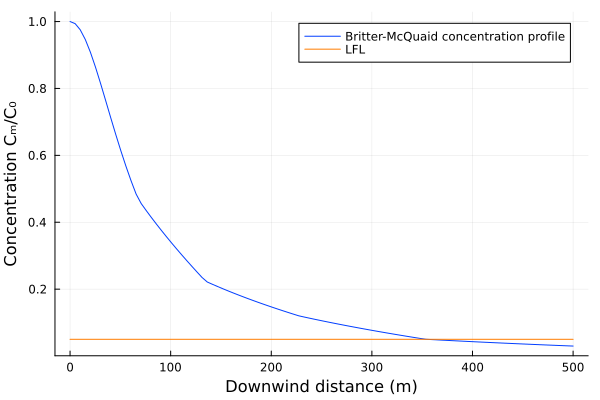

In [8]:
#| echo: false
#| label: fig-conc-profile
#| fig-cap: "The concentration profile for the Britter-McQuaid dense gas model, with the LFL shown for reference."

using Plots

let
    colours = palette(:seaborn_bright)
    xs = range(0.0, 500.0; length=100)*1u"m" 
    plot(xs, Cm, color=colours[1], lab="Britter-McQuaid concentration profile", 
         ylabel="Concentration Cₘ/C₀", xlabel="Downwind distance")
    plot!([0, 500], [LFL, LFL], lab="LFL", color=colours[2])
end

If all one needs is the distance to the LFL there is an easier way of doing this: interpolate the concentrations to find the *&beta;* corresponding to the LFL (after applying the non-isothermal correction). However, if one also requires the plume dimensions the concentration profile is required.

From the concentration profile calculating the downwind distance to the LFL is very straight-forward.

In [9]:
using Roots

xn = find_zero((x) -> Cm(x) - LFL, (300,400).*1u"m", Roots.Brent())

354.5630187009715 m

## Looking again at plume dimensions

At first glance the workbook seems to be giving the user everything they need to workout the size of the plume, giving the following diagram

::: {#fig-diagram}
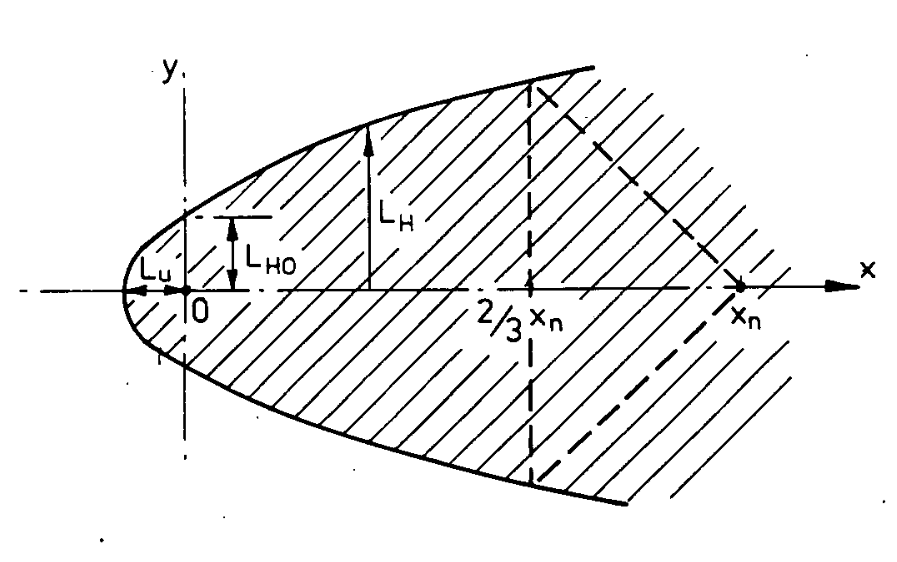

Dense plume concentration contour[@britter-1988 figure 10].
:::

and the following relations for the labeled distances

$$ L_U = {D \over 2} + 2 l_b $$

$$ L_{Ho} = D + 8 l_b $$

$$ L_H = L_{Ho} + 2.5 \sqrt[3]{ l_b x^2 } $$

with the buoyancy scale *l<sub>b</sub>* defined as
$$ l_b = { { g_o Q_o } \over u_{ref}^{3} } $$

In [10]:
lb = (gₒ*Qₒ)/u₁₀^3

0.18392758812310803 m

In [11]:
Lᵤ  = D/2 + 2lb

1.4973003373658906 m

In [12]:
Lₕₒ = D + 8lb

3.7303110272242135 m

In [13]:
#| output: false
Lₕ(x) = Lₕₒ + 2.5∛(lb*x^2)

Lₕ (generic function with 1 method)

### Upwind region

The curve given for *L<sub>H</sub>* for *x* &gt; 0 is **not** the curve for *x* &lt; 0, the upwind extent of the plume. This is the blue curve in the figure below. The orange curve is slightly adjusting *L<sub>H</sub>* such that for *x* &lt; 0 the second term is subtracted (so the curve actually converges to zero instead of blowing up to +&infin; as *x* &rarr; -&infin;). The black dots are points taken from the diagram given by Britter and McQuaid, using a graph digitizer and scaling to the actual *L<sub>Ho</sub>* and *L<sub>U</sub>*. Clearly the given curve for *L<sub>H</sub>* is not at all what is shown in the diagram for the upwind region.

A conservative approach to estimating the size of the upwind extent is to assume *L<sub>H</sub>* = *L<sub>Ho</sub>* for *L<sub>U</sub>* &lt; *x* &lt; 0, i.e. making the upwind region a rectangle of width *L<sub>Ho</sub>* and length *L<sub>U</sub>* [@bakkum-2005]. This is the green curve in the figure below.


Alternatively one could "fit" a curve to hit the end points while also having the same power of *x*: $L_H = L_{Ho} \left( {x + L_U} \over L_U \right)^{2/3}$ where *L<sub>U</sub>* &lt; *x* &lt; 0, this at least retains the same general shape and is the red curve in the figure below. I think this should be taken with the giant caveat that I don't know if insisting on the same power law is truly justified.

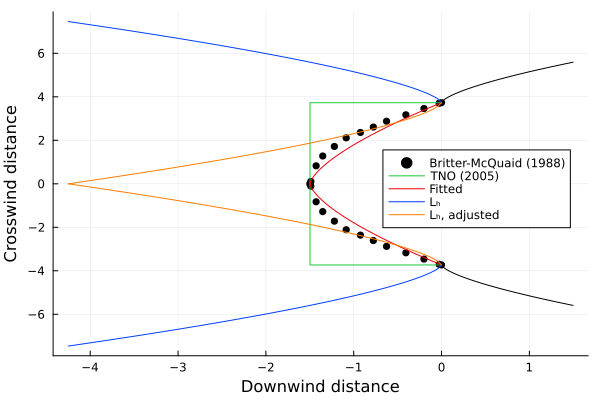

In [14]:
#| echo: false
#| label: fig-upwind
#| fig-cap: "The various approaches to estimating the upwind plume extent, black dots are a digitization of the corresponding diagram from Britter and McQuaid shown for reference."

using Plots

let

colors = palette(:seaborn_bright)

LUx = (Lₕₒ/(2.5*∛(lb)))^1.5

BM_digitized = [-1.0 0.0;
-0.9939717343569061 0.029319406894930733;
-0.9537135823452614 0.221687533134864;
-0.9033577977708811 0.34256351698544085;
-0.8146803507899527 0.46053382814730215;
-0.7250927776191833 0.5663716814159292;
-0.6168522219050345 0.6327433628318575
-0.5184934348968873 0.6994653932992492;
-0.41799920693587866 0.7712350452858585;
-0.2711457059020894 0.8504468697160665;
-0.13357302255297476 0.9279393173198471;
-0.01775545337837503 0.9926634313445617;
0.0 1.0]

xs = range(-Lᵤ, 0.0u"m", 100)
ext_xs = range(-LUx, 0.0u"m", 100)

original_curve(x) = Lₕₒ + 2.5*∛(lb*x^2)
extended(x) = Lₕₒ - 2.5*∛(lb*x^2)
fitted(x) = Lₕₒ*((x+Lᵤ)/Lᵤ)^(2/3)

plot(Lᵤ*BM_digitized[:,1], Lₕₒ*BM_digitized[:,2], color=:black, seriestype=:scatter, lab="Britter-McQuaid (1988)")
plot!(Lᵤ*BM_digitized[:,1], -Lₕₒ*BM_digitized[:,2], color=:black, seriestype=:scatter, lab=false)
plot!(-1*xs, original_curve.(-1*xs), color=:black, lab=false)
plot!(-1*xs, -1*original_curve.(-1*xs), color=:black, lab=false)
plot!([-Lᵤ; -Lᵤ; 0.0u"m"], [0.0u"m"; Lₕₒ; Lₕₒ], color=colors[3], lab="TNO (2005)")
plot!([-Lᵤ; -Lᵤ; 0.0u"m"], [0.0u"m"; -Lₕₒ; -Lₕₒ], color=colors[3], lab=false)
plot!(xs, fitted.(xs), color=colors[4], lab="Fitted")
plot!(xs, -1*fitted.(xs), color=colors[4], lab=false)
plot!(ext_xs, original_curve.(ext_xs), color=colors[1], lab="Lₕ")
plot!(ext_xs, -1*original_curve.(ext_xs), color=colors[1], lab=false)
plot!(ext_xs, extended.(ext_xs), color=colors[2], lab="Lₕ, adjusted")
plot!(ext_xs, -1*extended.(ext_xs), color=colors[2], lab=false)
plot!(ylabel="Crosswind distance", xlabel="Downwind distance", legend=:right)

end

For most typical cases I would think the upwind region would be a small component of the overall plume and taking the conservative, rectangle, approach would be a small error.

### Vertical extent

The vertical extent is not given on the diagram, but an equation is given in the text, with the note that this comes from continuity, however I think this is incorrect.

$$ L_V = {Q_o \over {u_{ref} L_H} } = { D^2 \over L_H } $$

Suppose a steady state plume with a system boundary such that the plume is sliced along the *y-z* plane at some downwind distance *x*. All of the mass entering the plume, from the source, exits the plume through this plane

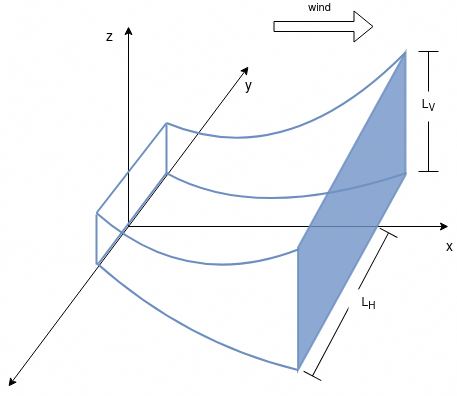

Consider the steady state mass balance

$$ \textrm{mass in} = \textrm{mass out} $$

$$ c_o Q_o = \iint_A c u \,dA = \int_{0}^{\infty} \int_{-\infty}^{\infty} c(x,y,z) u(x,y,z) \,dy \,dz $$

By the nature of a top-hat model the plume cross section is a rectangle with half-width *L<sub>H</sub>* and height *L<sub>V</sub>* and the concentration everywhere *inside* the rectangle is *c<sub>m</sub>*. Assuming a constant advection velocity, *u*, the integral can be simplified to

$$ \iint_A c u \,dA = c_m u \int_{0}^{L_V} \int_{-L_H}^{L_H} \,dy \,dz = 2 c_m u L_H L_V $$

The steady state mass balance is then

$$ c_o Q_o = 2 c_m u L_H L_V $$

and the vertical extent can be solved for with some simple re-arrangement

$$ L_V = { { c_o Q_o } \over { 2 c_m u L_H } } = {1 \over 2}{ c_o \over c_m } { Q_o \over {u L_H} } $$

Setting the advection velocity of the plume to the reference windspeed gives

$$ L_V = {1 \over 2}{ c_o \over c_m } { Q_o \over {u_{ref} L_H} } = {1 \over 2} { c_o \over c_m } { D^2 \over L_H }$$

In [15]:
#| output: false
Lᵥ(x) = D^2/(2*Cm(x)*Lₕ(x))

Lᵥ (generic function with 1 method)

This is definitely similar to what is given by Britter and McQuaid but with two big differences:

+ it depends upon the concentration
+ it is divided by two

The last point could equally be a mistake in the diagram (I have no real way of checking) as while the diagram shows *L<sub>H</sub>* as the plume *half-width*, the text simply refers to it as the "lateral plume extent", which is ambiguous -- do they mean the entire lateral extent or from the center-line of the plume? 

The TNO Yellow Book gives a different equation[@bakkum-2005 equation 4.104] for the vertical extent:

$$ L_V = {1 \over 2} { Q_o \over {u_{ref} L_H} } = {1 \over 2} { D^2 \over L_H }$$

Which clearly follows from assuming *L<sub>H</sub>* is the *half-width*, and the corresponding figure is labeled as such (using the same equation for *L<sub>H</sub>* as Britter and McQuaid). But it doesn't depend upon concentration.

I think the vertical extent has to depend upon the concentration as otherwise mass will simply disappear from the plume as it extends downwind. There is also the obvious problem that since the plume lateral extent monotonically increases, and the vertical extent is inversely related to it, the vertical extent is monotonically decreasing. In fact it becomes vanishingly small quite quickly. This entirely the opposite of what is observed with actual dense plume dispersion.

This can be seen most clearly in the following figure in which the vertical extent is shown as a function of downwind distance along with the mass flowrate in the plume (i.e. $c_m u A$ )

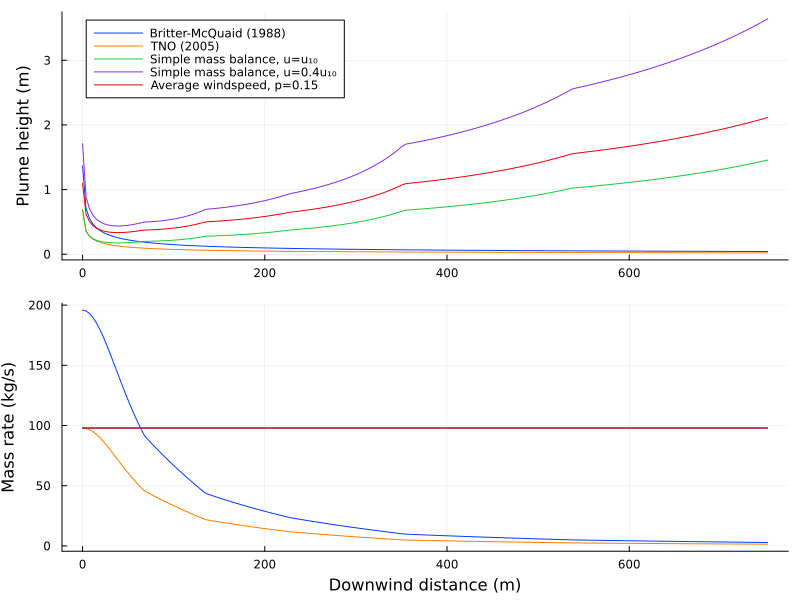

In [16]:
#| echo: false
#| label: fig-plume-height
#| fig-cap: "Approaches to plume height estimation (top) and the corresponding conservation of mass (bottom)."

using Plots

let

colours = palette(:seaborn_bright)

xs = range(0.0, 1.5*xff; length=200)*1u"m" 
Lv_BM(x) = D^2/Lₕ(x)
Lv_TNO(x) = 0.5*D^2/Lₕ(x)

function Lv(x; k=1) 
    return(1/(2*k))*D^2/(Cm(x)*Lₕ(x))
end

function Lv_uavg(x; p=0.15, z_r=10u"m") 
    return (((p+1)*(z_r^p)*D^2) / (2*Cm(x)*Lₕ(x)) )^(1/(p+1))
end

p1 = plot(xs, Lv_BM, color=colours[1], lab="Britter-McQuaid (1988)")
plot!(p1, xs, Lv_TNO, color=colours[2], lab="TNO (2005)")
plot!(p1, xs, Lv, color=colours[3], lab="Simple mass balance, u=u₁₀")
plot!(p1, xs, (x) -> Lv(x; k=0.4), color=colours[5], lab="Simple mass balance, u=0.4u₁₀")
plot!(p1, xs, Lv_uavg, color=colours[4], lab="Average windspeed, p=0.15")
plot!(p1, ylabel="Plume height (m)", xlabel="", legend=:topleft)

cₒ = ṁ/Qₒ
m_BM(x) = cₒ*Cm(x)*u₁₀*(2*Lₕ(x))*Lv_BM(x)
m_TNO(x) = cₒ*Cm(x)*u₁₀*(2*Lₕ(x))*Lv_TNO(x)

function m(x; k=1) 
    return cₒ*Cm(x)*k*u₁₀*(2*Lₕ(x))*Lv(x; k=k)
end

function m_uavg(x;  p=0.15, z_r=10u"m")
    return (cₒ*Cm(x)) * (u₁₀/(p+1))*(Lv_uavg(x)/z_r)^p * (2*Lₕ(x)*Lv_uavg(x; p=p, z_r=z_r))
end
    
p2 = plot(xs, m_BM, color=colours[1], lab="Britter-McQuaid 1988")
plot!(p2, xs, m_TNO, color=colours[2], lab="TNO 2005")
plot!(p2, xs, m, color=colours[3], lab="Simple mass balance, u=u₁₀")
plot!(p2, xs, (x) -> m(x; k=0.4), color=colours[5], lab="Simple mass balance, u=0.4u₁₀")
plot!(p2, xs, m_uavg, color=colours[4], lab="Average windspeed, p=0.15")
plot!(p2, ylabel="Mass rate (kg/s)", xlabel="Downwind distance (m)", legend=false)

plot(p1,p2; layout=@layout([°;°]), size=(800,600))
end

I think it is fairly obvious that both the Britter-McQuaid and TNO models give silly answers for the vertical extent. Though the corrected curve, the green curve, clearly has problems too: it has an odd bumpiness, as a result of the linear interpolation, and it is also too small due to both assuming the concentration everywhere is equal to the ground level concentration and due to an overly large advection velocity (the windspeed at 10m is quite a bit higher than the windspeed at ~1m).

An alternative approach to using the reference windspeed as the advection velocity is to assume the advection velocity is some constant fraction of the reference velocity, e.g. $u = 0.4 u_{ref}$, which is what Britter and McQuaid use for the instantaneous model.

Another alternative might be to use an *average* windspeed, *&umacr;* over cross-section of the plume as the advection velocity, assuming windspeed is only a function of height.

$$ \bar{u} = { { \iint_A u \,dA } \over A } =  { { \int_{0}^{L_V} u(z) \,dz } \over L_V } $$

Assuming the windspeed follows a powerlaw distribution $u = u_{ref} \left( z \over z_{ref} \right)^p$ gives

$$ \bar{u} = { { \int_{0}^{L_V} u(z) \,dz } \over L_V } $$

$$ = {1 \over L_V} \int_{0}^{L_V} u_{ref} \left( z \over z_{ref} \right)^p \,dz $$

$$ = { u_{ref} \over {p+1} } \left( L_V \over z_{ref} \right)^p $$

plugging it into the simple mass balance

$$ c_o Q_o = c_m \bar{u} A $$

$$ = c_m {u_{ref} \over {p+1} } \left( L_V \over z_{ref} \right)^p { 2 L_H L_V } $$

re-arranging to solve for *L<sub>V</sub>*

$$ L_V = \left( { {p+1} \over 2 } { c_o \over c_m } z_{ref}^p {Q_o \over {u_{ref} L_H} } \right)^{1 \over {p+1} } $$

$$ = \left( { {p+1} \over 2 } { c_o \over c_m } z_{ref}^p {D^2 \over L_H } \right)^{1 \over {p+1} }$$

The red curve in the figure above is this model, using *p* = 0.15[@ccps-1999 page 83]. 

This could also be done using the logarithmic windspeed curve $u = {u_{\star} \over \kappa} \log \left( z \over z_) \right)$ where $u_{\star}$ is the friction velocity and *z<sub>0</sub>* is the roughness length. Though I don't imagine the expression would work out as nicely.

### Recommendations

For the upwind region, assuming a simple rectangular prism with length *L<sub>U</sub>*, width *2L<sub>Ho</sub>*, height *L<sub>Vo</sub>* and uniform concentration *c<sub>o</sub>* is a conservative approach. Likely the plume downwind of the source will be much larger than the upwind area and so this will be a small overestimate.

The simple mass balance approach to calculating the plume height is a reasonable approach if one simply wants to reference Britter and McQuaid and not have to justify additional assumptions. It is not what is given in the text, but it is what is *described* in the text. The other models for plume height may be more realistic, in the sense that they represent more realistic advection velocities, and will give larger explosive masses for the plume, however they have not been validated against any actual data. That validation may be a worthwhile exercise but is well beyond the scope of this blog post.

## Calculating the explosive mass

The explosive mass in the cloud is the given by the volume integral

$$ m_e = \iiint_V c dV $$

where *V* is defined as the region where *c* &ge; *LFL*.[^LFL]

[^LFL]: Some sources recommend *1/2 LFL*.

Using the concentration profile and the plume extents, we could work out the function `c(x,y,z)` such that the concentration is returned if we are:

+ within the plume, and
+ the concentration is &ge; *LFL*

To determine the explosive mass in the downwind region this might be done by the following

```julia

cₒ = ustrip(u"kg/m^3", ṁ/Qₒ)

Lₕ(x::Number) = ustrip(u"m", Lₕ(x*1u"m"))
Lᵥ(x::Number) = ustrip(u"m", D)^2/(2*Cm(x)*Lₕ(x))

function c(x,y,z; lim=LFL)
    c_ = Cm(x)
    
    if c_ ≥ lim
        if (abs(y) ≤ Lₕ(x)) && (z ≤ Lᵥ(x))
            return cₒ*c_
        else
            return 0.0
        end
    else
        return 0.0
    end
end

```

```julia

using HCubature: hcubature

x_min, x_max = 0, xn
y_min, y_max = -Lₕ(xn), Lₕ(xn)
z_min, z_max = 0, Lᵥ(xn)

m_e, err = hcubature( c, [x_min, y_min, z_min], [x_max, y_max, z_max])

```

This is a pretty tedious integration, is very inefficient, and doesn't take into account any of the *structure* of the model and it turns out that a top-hat model has some pretty convenient structure.

### A nice property of top hat models

Returning to the integral for the explosive mass, the plume can be divided into an upwind region (*x* &lt; 0) and a downwind region (*x* &ge; 0)

$$ m_e = \iiint_V c \,dV = m_{e,u} + m_{e,d} $$

with the explosive mass of the downwind region being

$$ m_{e,d} = \int_0^{x_n} \iint_A c \,dA \,dx $$

For a top-hat model, since the concentration at a given downwind distance is constant everywhere within the plume cross-section $\iint_A c dA = c_m A$, and, from a mass balance on the plume

$$ c_m A u = c_o Q_o $$

$$ c_m A = { {c_o Q_o} \over u} $$

which is a constant, thus

$$ m_{e,d} = \int_0^{x_n} c_m A \,dx $$

$$ = \int_0^{x_n} { {c_o Q_o} \over u} \,dx $$

$$ = { {c_o Q_o} \over u} x_n $$

For the explosive mass of the upwind region a simple box model gives $m_{e,u} = 2 c_o L_U L_{Ho} L_{Vo}$. Putting everything together[^top-hat]

$$ m_e = 2 c_o L_U L_{Ho} L_{Vo} + { {c_o Q_o} \over u} x_n $$


[^top-hat]: This is not specific to the Britter-McQuaid model, it works for *any* top hat model.

This can be simplified greatly by setting the advection velocity to *u<sub>ref</sub>*

$$ m_e = 2 c_o L_U L_{Ho} L_{Vo} + { {c_o Q_o} \over u_{ref} } x_n $$

$$ = 2 c_o L_U L_{Ho} {1 \over 2}{D^2 \over L_{Ho} } + c_o D^2 x_n $$

$$ = c_o D^2 \left( L_U + x_n \right)$$

In [17]:
cₒ = ṁ/Qₒ

mₑ = cₒ*D^2*(Lᵤ+xn)

3197.617661470163 kg

This very simple expression is the obvious strength of a top-hat model: it makes calculating the explosive mass incredibly easy[@woodward-1998]. It also retroactively justifies why the Britter McQuaid model is oriented around calculating *x<sub>n</sub>*: that's all you actually need.[^ufl]

[^ufl]: Some sources recommend calculating the explosive mass as the region of the plume with the concentration *LFL* &le; *c* &le; *UFL*, in which case $m_e = c_o D^2 \left( x_{n,LFL} - x_{n,UFL} \right)$

If this seems too good to be true, the integration can be performed numerically by taking

$$ \iint_A c \,dA = c_m \cdot 2L_H \cdot L_V $$

In [18]:
using QuadGK: quadgk

function ∫∫cdA(x)
    if Cm(x) ≥ LFL
        return cₒ*Cm(x)*(2Lₕ(x))*Lᵥ(x)
    else
        return 0.0u"kg/m"
    end
end

m_ed, err = quadgk(∫∫cdA, 0u"m", xn)

m_eu = 2*cₒ*Lᵤ*Lₕₒ*Lᵥ(0u"m")

m_eu + m_ed

3197.617661470163 kg

Which is exactly the same.

Above I claimed the upwind region was "small" relative to the downwind region, this can be shown easily as the mass in each region is directly proportional to the length.

In [19]:
Lᵤ/(Lᵤ+xn)

0.004205187316042018

Since the mass in the upwind region is &lt;0.5% of the total mass in the cloud, I think the simple box model is justified.

### Added complications

According to Britter and McQuaid the top-hat model generates an overly conservative plume extent and they recommend using given the lateral extent curve up to *2/3 x<sub>n</sub>* and after which connecting to *x<sub>n</sub>* using straight lines, as shown in the plume diagram. This makes the integration for explosive mass a little more complicated.

For simplicity the plume can be divided into three regions, the upwind region (*x* &lt; 0), the downwind region up to the cutoff (0 &le; *x* &lt; 2/3 *x<sub>n</sub>*), and the downwind cutoff region (2/3 *x<sub>n</sub>* &le; *x* &lt; *x<sub>n</sub>* )

$$ m_{e, \textrm{cut off} } = m_{e,u} + m_{e,d1} + m_{e,d2} $$

The upwind region, *m<sub>e,u</sub>*, and the first downwind region *m<sub>e,d1</sub>* are already known, they are the same as above up to 2/3 *x<sub>n</sub>*. What is left to determine is the explosive mass in the cutoff region.

$$ m_{e,d2} = \int_{2/3 x_n}^{x_n} \iint_A c \,dA \,dx $$

The integral can be re-written to take advantage of *c<sub>m</sub>A* being an invariant for a top-hat model,

$$ m_{e,d2} = \int_{2/3 x_n}^{x_n} \iint_A c \,dA \,dx $$

$$ = c_m A_{\textrm{original} } \int_{2/3 x_n}^{x_n} { A_{\textrm{cut off} } \over A_{\textrm{original} } } \,dx $$

Assuming the vertical extent remains unchanged in this operation, the ratio of areas is the same as the ratio of horizontal extents

$$ { A_{\textrm{cut off} } \over A_{\textrm{original} } } = { L_{H, \textrm{cut off} } \over L_{H, \textrm{original} } } $$

From some simple geometry, the horizontal extent is

$$ L_{H, \textrm{cut off} } = 3 L_{H, 2/3 x_n}  { {x_n - x} \over x_n }$$

Which then leads to

$$ m_{e,d2} = 3 c_o D^2 \int_{2/3 x_n}^{x_n} { L_{H, 2/3 x_n} \over L_H } { {x_n - x} \over x_n } \,dx $$

There is probably a closed form for this integral but it is just as easy to integrate that numerically.

$$ m_{e, \textrm{cut off} } = c_o D^2 \left( L_U + \frac{2}{3}x_n + 3 L_{H, 2/3 x_n} \int_{2/3 x_n}^{x_n} { 1 \over L_H(x) } { {x_n - x} \over x_n } \,dx   \right)$$

In [20]:
mₑ_cutoff = cₒ*D^2*(Lᵤ + (2/3)*xn 
    + 3*Lₕ((2/3)*xn)*quadgk( (x) -> (xn - x)/(xn*Lₕ(x)), (2/3)*xn, xn)[1] )

2620.489605856347 kg

This works out to be about 20% less than the original explosive mass.

In [21]:
mₑ_cutoff/mₑ

0.8195131136008078

## Final thoughts

I think the error in the vertical extent may have limited the apparent utility of the Britter-McQuaid model. Most references I have do use the Britter-McQuaid model, noting that it is "reasonably simple to apply, and produces results which appear to be as good as more sophisticated models"[@ccps-1999 page 122], however they either claim that it is *only* good for calculating *x<sub>n</sub>* or gloss over how it could be used for anything else. The CCPS references seem consistent in neglecting to mention at all that the model can also estimate the plume extent. So, while I can't imagine I'm the first person to have noticed that the given equation for *L<sub>V</sub>* doesn't work, I have yet to encounter anyone *actually admitting it*.


That said, the correction also seems obvious to me: one simply follows what is described in the text which is exactly how Britter and McQuaid calculated the cloud height for the instantaneous model (which is correct) in the same workbook. That the incorrect equation for *L<sub>V</sub>* is repeated in other references[@lees-1996; @casal-2018], with only the *TNO Yellow Book*[@bakkum-2005] making a correction, while still repeating a critical mistake, strikes me as very odd.


The Britter-McQuaid model would seem to be the perfect fit for screening models, which are often only order of magnitude estimates at best anyways. It gives reasonable concentrations, plausible plume extents, and the explosive mass is ridiculously easy to calculate (slightly more tedious if you are using the 2/3 cut-off region but nothing that couldn't be worked out in advance if this was going to be incorporated into a routine calculation tool).

## References
::: {#refs}
:::